# Imports

In [26]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
import networkx as nx
from tqdm import trange

# Matrix Generators


Let's build different topology of network. 

For the sake of benchmarking, it is interesting to have control on the number of node and the average number of edges per node. That's why some function were re-implmented.

But first, here is a function that gives some informations about the network that will be built.

Note : All network are represnted throught their incidence matrix.

In [27]:
def info_graph(A) :
  G = nx.from_numpy_array(A)
  print("Average number of edges : ",sum(sum(A))/len(A))
  #print("Sigma Coefficient (sw if >1) : ", nx.sigma(G))
  #print("Omega Coefficient (sw if 0) : ", nx.omega(G))
  plt.figure()
  plt.imshow(A)
  plt.figure()
  plt.plot(nx.degree_histogram(nx.from_numpy_array(A)))
  plt.xlabel("Degree")
  plt.ylabel("Frequency")

Average number of edges :  64.32421875


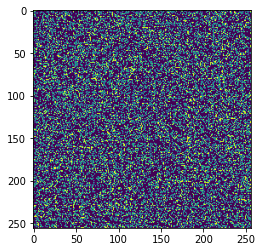

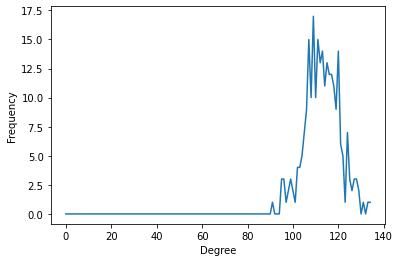

In [4]:
# Function that create a random graph
def create_random(N,  k_avg):
  ret = np.zeros((N, N))
  A = np.random.uniform(size=(N,N))
  ret[:N,:N] = np.array(1*(A<(k_avg/N)))
  return ret

info_graph(create_random(256, 64))

Average number of edges :  64.0


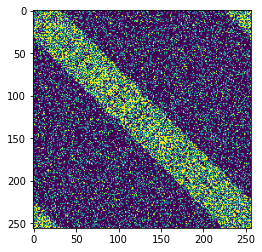

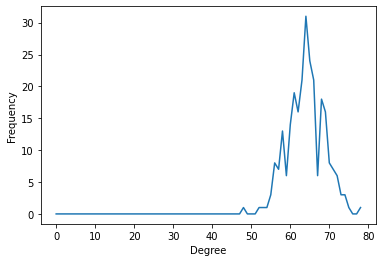

In [5]:
# Function that create a Small wolrd Watts Stoggart network.
def create_WS(N, k_avg, p_drop = 0.5):
  A = np.zeros((N, N))
  G = nx.connected_watts_strogatz_graph(N, k_avg, p_drop)
  A[:N, :N] = nx.to_numpy_array(G)#[K:,K:]
  return A

info_graph(create_WS(256, 64))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Average number of edges :  11.8203125


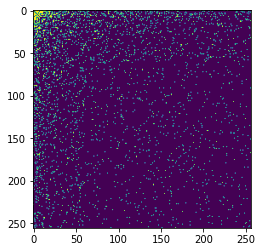

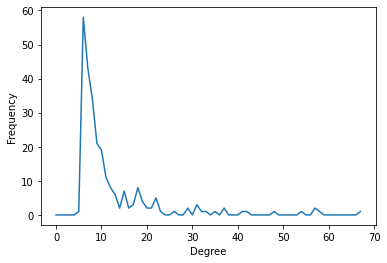

In [6]:

# Create a Barabasi-Albert network
def BA(N, M0, m) :
    """
        N, number of nodes in the final network.
        M0, initial connected network of M0 nodes.
        m, Each new node is connected to m existing nodes.
    """
    assert( M0 < N )
    assert( m <= M0 )
    
    #adjacency matrix
    AM = np.zeros((N,N))
    
    for i in range(0, M0):
        for j in range(i+1,M0):
            AM[i,j] = 1
            AM[j,i] = 1
    
    # add 'c' node
    for c in range(M0,N):
        Allk = np.sum(AM)  # all  degree    Eki
        ki = np.sum(AM , axis = 1)   # ki each degree for node i
        
        pi = np.zeros(c,dtype=np.float) # probability
        for i in range(0,c):
            pi[i] = ki[i]/(Allk*1.0)
        # print pi
    
        # connect m edges.
        for d in range(0,m):
            rand01 = np.random.random()  #[0,1.0)
            
            sumpi = 0.0
            for g in range(0,c):
                sumpi += pi[g]
                if sumpi>rand01 :  # connect 'c' node with 'g' node.
                    if AM[c,g]==0 and AM[g,c]==0 :
                        AM[c,g] += 1
                        AM[g,c] += 1                    
                        break
    
    return AM    

# Build a Barabasi-Albert Network with same M0 = m and with the right average number of edges per node.
def create_BA(N, k_avg):
  M = int((-1+2*N-((1-2*N)**2-4*N*k_avg)**(1/2))//2)+1
  return BA(N,M,M)

A = create_BA(256,10)
info_graph(A)



Average number of edges :  127.78125


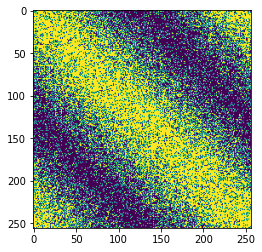

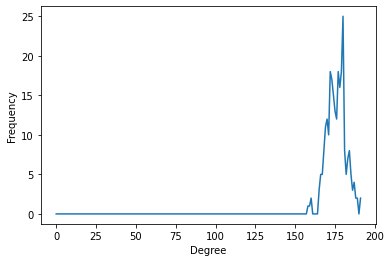

In [7]:
def gaussian_connect(N, sigma, mu, tol=1e-6, quantile_max=30):
    alpha = 3 / quantile_max ** 2 - norm.cdf(-quantile_max) / norm.pdf(-quantile_max) * 3 / quantile_max
    assert mu ** 2 / 12 * (1 + alpha) < sigma ** 2, "Error: mu ** 2 / 12 > sigma ** 2"
    assert sigma ** 2 < N ** 2 / 12, "Error: sigma ** 2 > N ** 2 / 12"
    mu_target = mu
    sigma_target = sigma
    margin = sigma * np.sqrt(np.maximum(np.log(mu ** 2 / 2 / np.pi / sigma ** 2), 0))
    while True:        
        cdf_diff = norm.cdf(- margin / sigma) - norm.cdf(- N / 2 / sigma)
        if margin:
            mu = np.sqrt(2 * np.pi) * sigma * np.exp(margin ** 2 / 2 / sigma ** 2)
        else:
            mu = mu_target / 2 / cdf_diff
        b = - mu * np.sqrt(2 / np.pi) * N / 2 * np.exp(- (N / 2) ** 2 / 2 / sigma ** 2) / mu_target
        c = 2 / 3 * margin ** 3 / mu_target - sigma_target ** 2
        if np.abs(2 * mu * cdf_diff + 2 * margin - mu_target) < tol and \
            np.abs(sigma ** 2 + b * sigma + c) < tol:
            break
        sigma = np.sqrt(- (c + b * sigma))
        if margin:
            margin = np.maximum(mu_target / 2 - mu * cdf_diff, 0)
        else:
            margin = sigma * np.sqrt(np.maximum(np.log(mu ** 2 / 2 / np.pi / sigma ** 2), 0))
    x, y = np.meshgrid(range(N), range(N))
    d = np.minimum(np.mod(x - y, N), np.mod(y - x, N))
    return np.random.rand(N, N) <= mu / np.sqrt(2 * np.pi) / sigma * np.exp(- d ** 2 / 2 / sigma ** 2)


# Create a graph in which the probability of having an edge between any given pair of nodes is a Guassian distribution with respect to the distance between them.
def create_diago_chenxi(N, k_avg) :
  A = np.zeros((N, N))
  quantile_max = 30
  alpha = 3 / quantile_max ** 2 - norm.cdf(-quantile_max) / norm.pdf(-quantile_max) * 3 / quantile_max
  min_sigma = (k_avg ** 2 / 12 * (1 + alpha))**(1/2) 
  max_sigma = (N ** 2 / 12)**(1/2)
  g = gaussian_connect(N, (min_sigma+max_sigma)*(1/2), k_avg)
  A[:N, :N] = g
  return A


A = create_diago_chenxi(256, 128)
info_graph(A)

Average number of edges :  480.84375


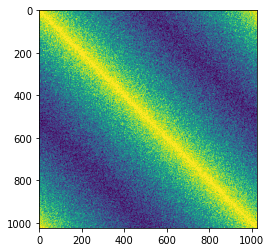

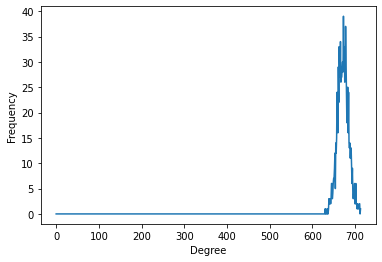

In [46]:
# Create a network with the number of connection depending of the function f along the distance
def create_distance_dependant(N, func, circular = True):
  x, y = np.meshgrid(range(N), range(N))
  if circular : A = np.minimum(np.mod(x - y, N), np.mod(y - x, N))
  else :        A = np.abs(x-y)
  return np.vectorize(func)(A)


def linear(x): return x
def uni_proba(x) : return np.random.uniform(0,1)<x
def minus_x_square(N, exp):
  return lambda x: uni_proba(((N-x)/N)**exp)

N = 1024
A = create_distance_dependant(N, minus_x_square(N, 3) , circular = True) 
info_graph(A)

# Average number of nodes should be N/3 Due to the fact that integral of ((N-x)/N)**2 from 0 to N is equal to N/3

# Implemeting the mapping algorithm

Here is the algorithm. 
It consists in switching the label of nodes. The underlying network remains the same, but not its incidency matrix. It is a greedy algorithm that search the best representation of the network. It maximizes a cost function that reperesnt the similarity with the Mask.


For example, if one wants to build four communities. It means that, those four communities should have as much intra-communities connection and as less as possible inter-commmunities connection. Then the cost function should penalizes the inter-communities connections and reward the intra-communities connections.

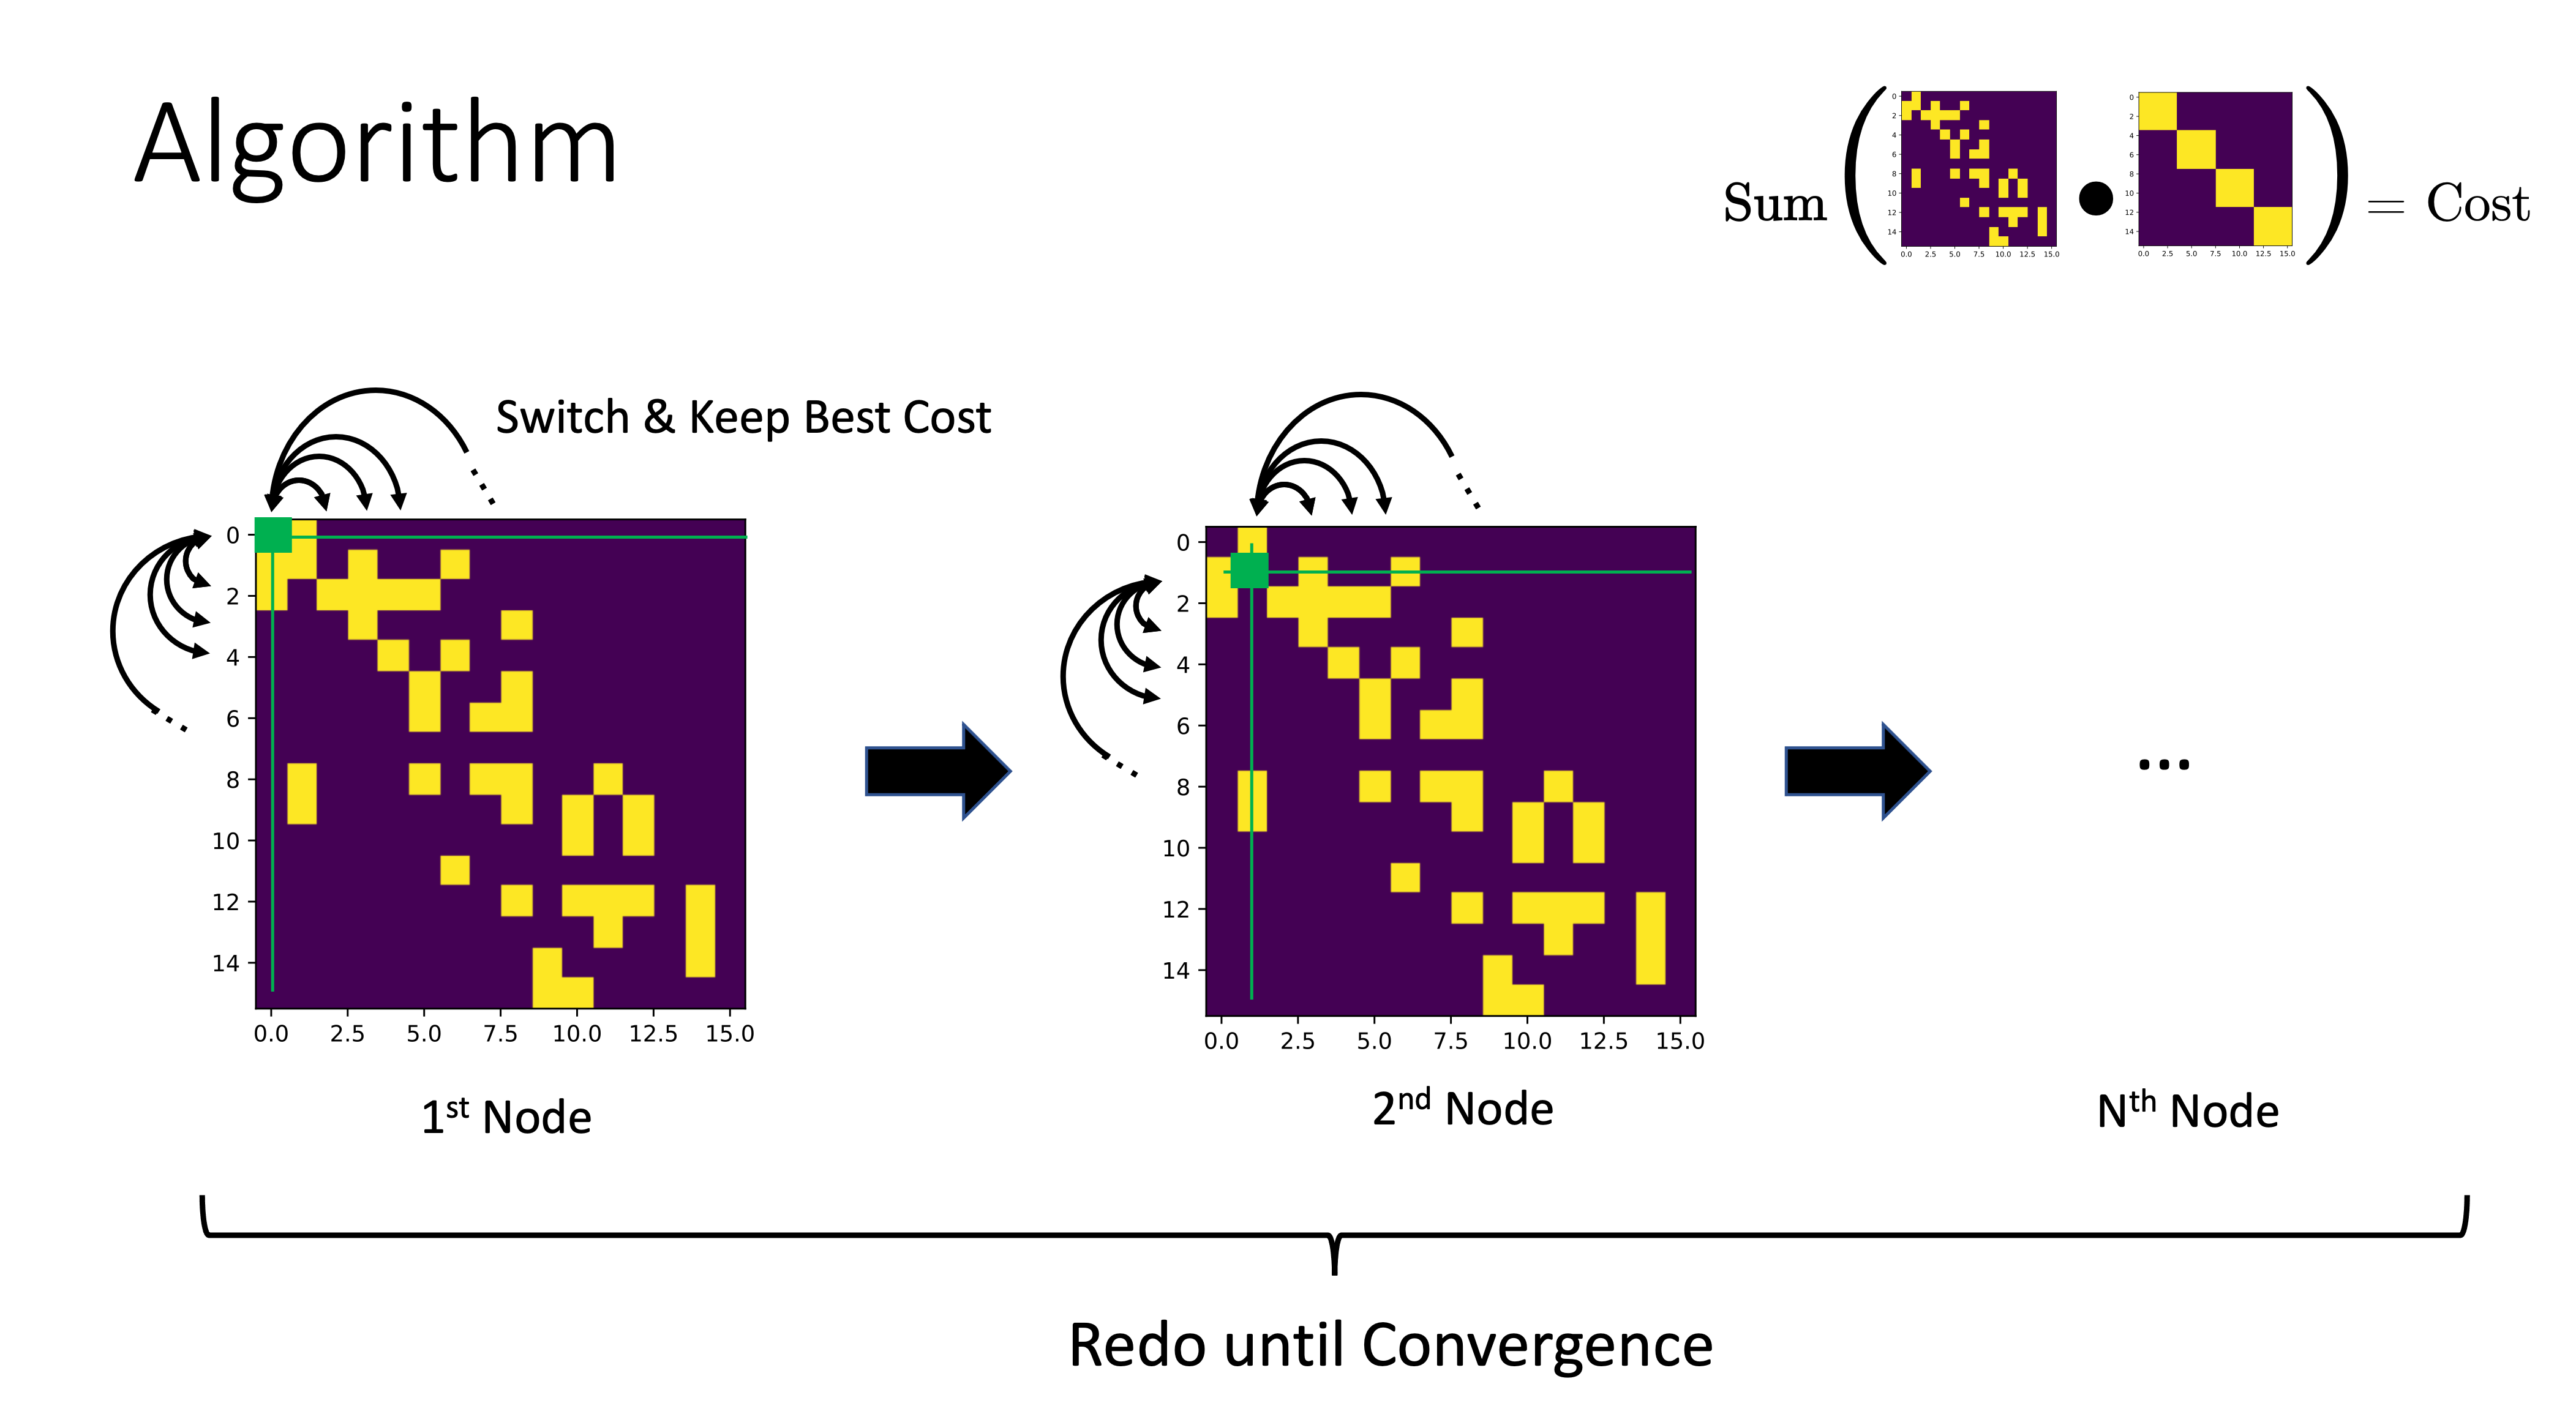

## Utils

To speed up the execution of the algorithme, let's use numba that allows Just In Time compilation.

In [9]:
from numba import jit

In [10]:
# Implementation of copying an array to use numba
@jit
def copyto_numba(a, b):
    N = len(a)
    for i in range(N):
        b[i] = a[i]

@jit
def copyto_numba_array(A,B):
    N = len(A)
    for i in range(N):
      for j in range(N):
        B[i,j] = A[i,j]


# Swap two node's label in a network. It does not change the network but it's matrix representation
@jit
def swap(A_new, buf, i, j):
  copyto_numba(A_new[i,:], buf)
  #np.copyto(buf, A_new[i,:])
  A_new[i,:] = A_new[j,:]
  A_new[j,:] = buf

  copyto_numba(A_new[:,i],buf)
  #np.copyto(buf, A_new[:,i])
  A_new[:,i] = A_new[:,j]
  A_new[:,j] = buf
  return A_new

# Swap two elements in a list
@jit
def swap_order(order, i, j):
  x = order[i]
  order[i] = order[j]
  order[j] = x 


# Create a reordered matrix along new labels
def reorder(partitions, A):
  order_ = np.ndarray.flatten(partitions)
  A_ord_line = np.zeros_like(A)
  for i in range(len(order_)):
    A_ord_line[i] = A[order_[i]]
  A_ord_col = np.zeros_like(A)
  for i in range(len(order_)):
    A_ord_col[:,i] = A_ord_line[:,order_[i]]
  return A_ord_col

# Reorder a list of matrix along a list of labels
def reorder_list(order, l):
  return np.array([l[i] for i in order])

# Shuffle the label of a network. The etwork remains the same but not its incidency matrix.
def shuffle(A):
  A_new = np.copy(A)
  arr = np.arange(len(A_new))
  np.random.shuffle(arr)
  A_new = reorder(arr, A_new)
  return A_new

Let's test if it is working properly

In [11]:
# Creating a matrix such that the elements with value 10*i+j describe the vertices from node i to node j
A = np.arange(0,100)
A = np.resize(A, (10,10))
print(A)

[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47 48 49]
 [50 51 52 53 54 55 56 57 58 59]
 [60 61 62 63 64 65 66 67 68 69]
 [70 71 72 73 74 75 76 77 78 79]
 [80 81 82 83 84 85 86 87 88 89]
 [90 91 92 93 94 95 96 97 98 99]]


Checking the swapping

In [12]:
swap(A,np.arange(len(A)),1,9)
print(A)

[[ 0  9  2  3  4  5  6  7  8  1]
 [90 99 92 93 94 95 96 97 98 91]
 [20 29 22 23 24 25 26 27 28 21]
 [30 39 32 33 34 35 36 37 38 31]
 [40 49 42 43 44 45 46 47 48 41]
 [50 59 52 53 54 55 56 57 58 51]
 [60 69 62 63 64 65 66 67 68 61]
 [70 79 72 73 74 75 76 77 78 71]
 [80 89 82 83 84 85 86 87 88 81]
 [10 19 12 13 14 15 16 17 18 11]]


Checking the shuffling

In [13]:
A_shuffled = shuffle(A)
print(A_shuffled)

[[11 16 17 12 13 14 10 15 18 19]
 [61 66 67 62 63 64 60 65 68 69]
 [71 76 77 72 73 74 70 75 78 79]
 [21 26 27 22 23 24 20 25 28 29]
 [31 36 37 32 33 34 30 35 38 39]
 [41 46 47 42 43 44 40 45 48 49]
 [ 1  6  7  2  3  4  0  5  8  9]
 [51 56 57 52 53 54 50 55 58 59]
 [81 86 87 82 83 84 80 85 88 89]
 [91 96 97 92 93 94 90 95 98 99]]


It's working ! The above matrix should prove you that shuffling the node label of a network change its incidence matrix but not the network itself. 

## Defining the Cost Function

In [14]:
class Cost():
  def cost(A):
    pass

  def cost_update(A, i, j):
    pass
import time

In [15]:
@jit
def cost_update_mask_jit(A, Mask, i, j):
    if i== j: return 0
    update =   (((A[j,:]-A[i,:])*Mask[i,:]).sum()
              + ((A[i,:]-A[j,:])*Mask[j,:]).sum()
              + ((A[:,j]-A[:,i])*Mask[:,i]).sum() 
              + ((A[:,i]-A[:,j])*Mask[:,j]).sum()
              + ((A[i,i]+A[j,j]-2*A[j,i])*Mask[i,i])
              + ((A[j,j]+A[i,i]-2*A[i,j])*Mask[j,j])
              + ((A[i,j]+A[j,i]-2*A[j,j])*Mask[i,j])
              + ((A[j,i]+A[i,j]-2*A[i,i])*Mask[j,i]))
    
    return update

class Cost_Mask(Cost) :
  def __init__(self, Mask):
    self.Mask = Mask

  # Returns the number of common elements between a matrix and a mask.
  def cost(self,A):
    return (A*self.Mask).sum()

  # Compute the difference of cost function between a matrix A and the same matrix A but with the label i and j switched
  def cost_update_slow(self, A, i, j):
    X = np.zeros_like(A)
    np.copyto(X, A)

    old_cost = (X*self.Mask).sum()
    swap(X, np.zeros(len(X)), i, j)
    new_cost = (X*self.Mask).sum()
    return new_cost-old_cost 

  # Do the same thing as cost_update_slow() but much faster (O(n) instead of O(n^2))
  def cost_update(self, A, i, j):  
    return cost_update_mask_jit(A, self.Mask, i, j)

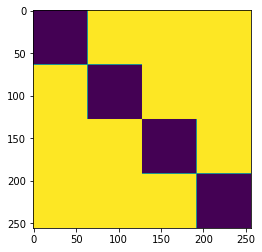

In [8]:
# Create a Mask representing a network of N nodes with C communities
def create_communities(N, C):
  A = np.zeros((N,N))
  for i in range(C):
    A[(N//C)*i:(N//C)*(i+1),(N//C)*i:(N//C)*(i+1)] = 1
  return A.astype(np.int64)

Mask = 1-create_communities(256,4)
plt.imshow(Mask)

In [16]:
A = create_communities(4,2)
print(A)

Mask = 1-create_communities(4,2) # Lower the cost for maximal likeliness. By penelizing elements that does not look like the mask
print(Mask)

MyCost = Cost_Mask(Mask)
print(MyCost.cost(A)) #Should print 0

[[1 1 0 0]
 [1 1 0 0]
 [0 0 1 1]
 [0 0 1 1]]
[[0 0 1 1]
 [0 0 1 1]
 [1 1 0 0]
 [1 1 0 0]]
0


In [17]:
print("Old Cost : ",MyCost.cost(A))

print("Update Cost (fast) : ",MyCost.cost_update(A, 1, 3))
print("Update Cost (slow) : ",MyCost.cost_update_slow(A, 1, 3)) 

swap(A, np.zeros(len(A)), 1, 3)

print("New Cost : ", MyCost.cost(A))
print(A)

Old Cost :  0
Update Cost (fast) :  4
Update Cost (slow) :  4
New Cost :  4
[[1 0 0 1]
 [0 1 1 0]
 [0 1 1 0]
 [1 0 0 1]]


## Starting Point

Choosing a good starting solution might be usefull for fastest convergence. Several ordering techniques exists such as Reverse Cuthill-McKee Reordering or Spectral reordering. Note that those techniques does not give all the time the same results for different shuffling. 

Comparison of ordering techniques for small world unravelling are disccussed in [Higham, D. J. (2003). Unravelling small world networks. Journal of Computational and Applied Mathematics, 158(1), 61-74.](https://reader.elsevier.com/reader/sd/pii/S0377042703004710?token=274E4E452FC2D99BB6BA338E35C19AD67D39C7EB692A8C8416B186F30EAA0324C35153A3FAA3CB41960BB3F8F41431F6&originRegion=eu-west-1&originCreation=20221106212743)

Note 1: In this paper, the small world networks treated are not circular.

Note 2: The spectral reordering exposes a high computational complexity when dealing with non small world network

In [18]:
def ordering(A, ord_type = None) :
  graph_netx = nx.from_numpy_matrix(A)

  if ord_type == "RCM" : # pre-ordering with reverse-cuthill-mckee
    new_order = nx.utils.reverse_cuthill_mckee_ordering(graph_netx)

  elif ord_type == "SPECTRAL"  : # pre-ordering with spectral ordering
    new_order = nx.spectral_ordering(graph_netx)
  
  else : return A

  return reorder(np.array(list(new_order)), A)  

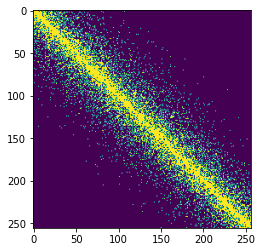

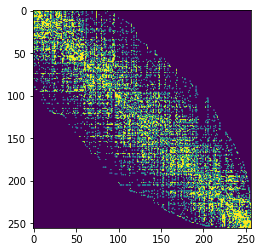

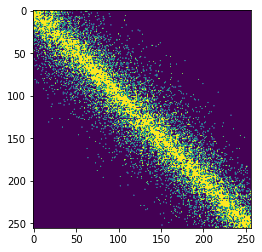

In [19]:
N = 256
A = create_distance_dependant(N, minus_x_square(N, 10) , circular = False )
#A = create_random(N, N//2) # Shows that spectral ordering has a high complexity
plt.imshow(A)
A_shuffled = shuffle(A)

A_rcm = ordering(A_shuffled, "RCM")
plt.figure()
plt.imshow(A_rcm)


A_spec = ordering(A_shuffled, "SPECTRAL")
plt.figure()
plt.imshow(A_spec)


## Implementing the algorithm

In [20]:
# This function reorder a matrix such that it minimizes a cost computed with the mask.
# The results could vary for the same matrix depending on the shuffling of its incidency matrix.
# In order to have the same results for two different shuffling, one could pre-order it with a reverse-cuthill-mckee order.

# Returns a new reordered matrix and the order applied on the initial matrix.

def mapping(A, Cost, ordering_type=None, maxIter = 10, debug = False):

  if debug : print("INITIAL COST = ", Cost.cost(A))

  lenght = len(A)
  buf = np.arange(lenght)
  A_new = A.copy()

  A_new = ordering(A_new, ordering_type)
  
  count_swap = 0
  count_total = 0
  improvement = True
  iter = 0
  while improvement and iter<=maxIter:
    improvement = False
    iter += 1

    for i in trange(lenght, desc = "Iteration number: "+str(iter), leave= True, disable = not debug):
      for j in range(lenght):
        count_total += 1
        if (Cost.cost_update(A_new, i, j) < 0) : 
          improvement = True
          swap(A_new, buf, i, j)
          count_swap += 1

  if debug : 
    print("\nFINAL COST = ", Cost.cost(A_new))
    print("Count swap = ", count_swap, ", proportion : " ,count_swap/count_total)
    print("Count notwap = ", count_total-count_swap, ", proportion : " , (count_total-count_swap)/count_total)

  return A_new

# Testing the algorithm




In [21]:
N = 256

Let's create a Cost Function, for example that target a four communities network

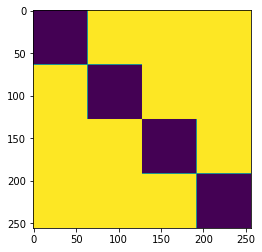

In [22]:
Mask = 1-create_communities(N,4)
MyCost = Cost_Mask(Mask)
#Mask = create_random(N,int(N**(1/2)))
plt.imshow(Mask)

Then we need a matrix to be treated. Let's say that matrix observed has a Watt's Stogart topology.

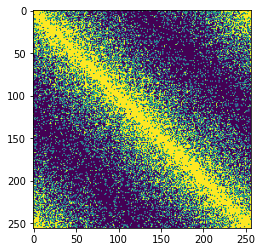

In [23]:
A = create_distance_dependant(N, minus_x_square(N, 4) , circular = True) 
#A = create_WS(N,int(N//2))
#A = create_diago_chenxi(256,50)
#A = create_random(N,int(N/2))
plt.imshow(A)

Let's shuffle the incidency matrix. Remember, the network remains the same.

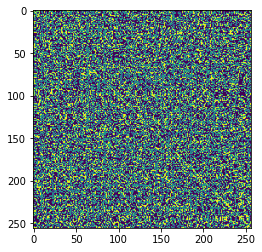

In [24]:
A_shuffled = shuffle(A)
plt.imshow(A_shuffled)

Now let's apply the algorithm !

Cost before shuffling : 13647.0
INITIAL COST =  18912.0


Iteration number: 3: 100%|██████████| 256/256 [00:00<00:00, 722.26it/s]


FINAL COST =  13515.0
Count swap =  942 , proportion :  0.004791259765625
Count notwap =  195666 , proportion :  0.995208740234375


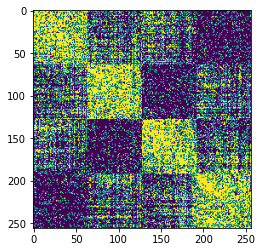

In [25]:
print("Cost before shuffling :", MyCost.cost(A))
Result = mapping(A_shuffled, MyCost, ordering_type = "RCM", debug = True)
plt.imshow(Result)

Compelxity observed :



```
Nodes | it/sec | time [s]
100   | 3200   | ~0.15
200   | 1200   | ~0.5
400   | 300    | ~4.0
800   | 80     | ~30
```

==> Complexity is O(n^3), because doubling n multiply by 8 the time.

This could have been expected because :    
- O(n^2) for testing all the possible swapping
- O(n) for update_cost computation

## Benchmarking

In [26]:
import pandas as pd
from numpy import genfromtxt

In [27]:
Intra_32_bis = [[ 56.,  78.,  96., 115., 141., 167., 190., 200., 225.],
                  [ 51.,  60.,  88.,  97., 133., 151., 171., 185., 210.],
                  [ 48.,  80.,  80., 100., 116., 143., 137., 159., 179.]]
Total_32_bis =  [[ 71.,  93., 127., 156., 192., 224., 271., 273., 327.],
                 [ 72.,  85., 130., 143., 198., 228., 251., 293., 325.],
                 [ 63., 124., 126., 167., 198., 248., 243., 289., 320.]]
 
Intra_32 =     [[ 77.,  89., 117., 135., 154.],
                  [ 67.,  90., 107., 123., 143.],
                  [ 70.,  72.,  99., 103., 141.],
                  [ 52.,  73.,  87., 107., 118.],
                  [ 52.,  73.,  77.,  91., 120.]]
Total_32 =      [[ 97., 116., 161., 179., 215.],
                 [ 90., 135., 151., 188., 225.],
                 [105., 108., 165., 169., 250.],
                 [ 81., 134., 152., 199., 231.],
                 [ 86., 133., 154., 176., 246.]]


Intra_16 =     [[16., 22., 35., 42., 50., 58.],
                [14., 19., 29., 34., 46., 51.]]
Total_16 =     [[17., 30., 52., 64., 77., 94.],
                [18., 32., 42., 62., 87., 94.]]

Cost_BF_16 = np.array([     [ 1.,  8., 17., 22., 27., 36.],
                            [ 4., 13., 13., 28., 41., 43.]])

Cost_BF_32 = np.array([     [ 20.,  27.,  44.,  44.,  61.],
                            [ 23.,  45.,  44.,  65.,  82.],
                            [ 35.,  36.,  66.,  66., 109.],
                            [ 29.,  61.,  65.,  92., 113.],
                            [ 34.,  60.,  77.,  85., 126.]])

Cost_BF_32_bis = np.array([[ 15.,  15.,  31.,  41.,  51.,  57.,  81.,  73., 102.],
                           [ 21.,  25.,  42.,  46.,  65.,  77.,  80., 108., 115.],
                           [ 15.,  44.,  46.,  67.,  82., 105., 106., 130., 141.]])

In [28]:
!wget https://raw.github.com/jiweber/Constrained-Mapping/main/Bruteforce_results.zip
!unzip -q /content/Bruteforce_results.zip

--2022-11-08 16:06:41--  https://raw.github.com/jiweber/Constrained-Mapping/main/Bruteforce_results.zip
Resolving raw.github.com (raw.github.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.github.com (raw.github.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/jiweber/Constrained-Mapping/main/Bruteforce_results.zip [following]
--2022-11-08 16:06:41--  https://raw.githubusercontent.com/jiweber/Constrained-Mapping/main/Bruteforce_results.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68987 (67K) [application/zip]
Saving to: ‘Bruteforce_results.zip’

Bruteforce_results. 100%[===================>]  67.37K  --.-KB/s    in 0.02s   

In [29]:
def benchmarking(test):
  Mask_16 = create_communities(16,4)
  MyCost_16 = Cost_Mask(1-Mask_16)
  Cost_algo_16  = np.full([2, 6], np.inf)

  Mask_32 = create_communities(32,4)
  MyCost_32 = Cost_Mask(1-Mask_32)
  Cost_algo_32  = np.full([5, 5], np.inf)
  Cost_algo_32_bis  = np.full([3, 9], np.inf)

  Diff = np.zeros(test)

  for i in trange(test) :
    for sig in range(2):
      for mu in range(6):
        my_data = genfromtxt('./Bruteforce_results/Noisy_diagonal_16/Noisy_diagonal_16_sigma_'+str(sig+2)+'_mu_'+str(mu+1)+'.csv', delimiter=',')
        my_data = shuffle(my_data)
        A = mapping(my_data, MyCost_16)
        Cost_algo_16[sig, mu] = min(Cost_algo_16[sig, mu], MyCost_16.cost(A))
        Diff[i] += Cost_algo_16[sig, mu] - Cost_BF_16[sig, mu]

    for sig in range(5):
      for mu in range(5):
        my_data = genfromtxt('./Bruteforce_results/Noisy_diagonal_32/Noisy_diagonal_32_sigma_'+str(sig+3)+'_mu_'+str(mu+3)+'.csv', delimiter=',')
        my_data = shuffle(my_data)
        A = mapping(my_data, MyCost_32)
        Cost_algo_32[sig, mu] = min(Cost_algo_32[sig, mu], MyCost_32.cost(A))
        Diff[i] += Cost_algo_32[sig, mu] - Cost_BF_32[sig, mu] 

    for sig in range(3):
      for mu in range(9):
        my_data = genfromtxt('./Bruteforce_results/Noisy_diagonal_32_bis/Noisy_diagonal_32_sigma_'+str(sig+3)+'_mu_'+str(mu+2)+'.csv', delimiter=',')
        my_data = shuffle(my_data)
        A = mapping(my_data, MyCost_32)
        Cost_algo_32_bis[sig, mu] = min(Cost_algo_32_bis[sig, mu], MyCost_32.cost(A))
        Diff[i] += Cost_algo_32_bis[sig, mu] - Cost_BF_32_bis[sig, mu]

  return (Cost_algo_16, Cost_algo_32, Cost_algo_32_bis, Diff)


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


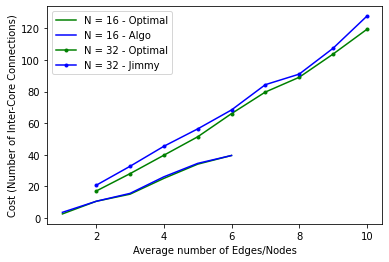

In [30]:
(Cost_algo_16, Cost_algo_32, Cost_algo_32_bis, Diff) = benchmarking(test = 1)


fig1 = plt.figure()
plt.plot(np.arange(1,7), np.mean(Cost_BF_16, axis = 0), 'g-', label = "N = 16 - Optimal")
plt.plot(np.arange(1,7), np.mean(Cost_algo_16, axis = 0),'b-', label = "N = 16 - Algo")

# plt.plot(np.arange(3,8), np.mean(Cost_BF_32, axis = 0), 'g*-')
# plt.plot(np.arange(3,8), np.mean(Cost_algo_32, axis = 0), 'b*-')

plt.plot(np.arange(2,11), np.mean(Cost_BF_32_bis, axis = 0), 'g.-', label = "N = 32 - Optimal")
plt.plot(np.arange(2,11), np.mean(Cost_algo_32_bis, axis = 0), 'b.-', label = "N = 32 - Jimmy")

plt.ylabel("Cost (Number of Inter-Core Connections)")
plt.xlabel("Average number of Edges/Nodes")
plt.legend()

#fig1.savefig("Comparison.pdf", format = "pdf")

100%|██████████| 50/50 [00:19<00:00,  2.60it/s]


Text(0, 0.5, 'Relative error in [%]')

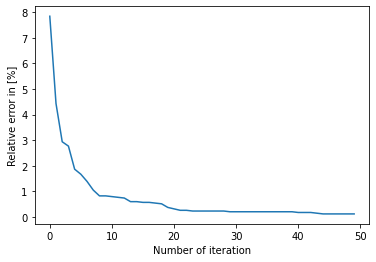

In [31]:
fig2 = plt.figure()
test = 50
(Cost_algo_16, Cost_algo_32, Cost_algo_32_bis, Diff) = benchmarking(test)
tot = (np.sum(Cost_BF_16)+np.sum(Cost_BF_32)+np.sum(Cost_BF_32_bis))

p = plt.plot(np.arange(test), 100*Diff[:]/(tot) )#, 'r-', label = "N = 16 - Optimal")

plt.xlabel("Number of iteration")
plt.ylabel("Relative error in [%]")

#pyplot.yscale('log')
#fig2.savefig("Error.pdf", format = "pdf")

## Gain with the algorithm

In [55]:
def plot3D(x, y, z, x_step, y_step, z_label = None, title = None,) :
  A = z
  new = np.zeros_like(A)
  for i in range(A.shape[0]):
    new[i, :] = A[A.shape[0]-i-1,:]

  plt.imshow(new, extent = (x[0]+x_step/2, x[-1]+x_step/2, y[0]+y_step/2, y[-1]+y_step/2), aspect = 'auto')
  cbar = plt.colorbar()

  plt.xlabel("Average Connectivity Probability")
  plt.ylabel("Number of Node")
  cbar.set_label(z_label)
  plt.yticks(np.arange(y_step, y[-1]+y_step, y_step))
  plt.xticks(np.arange(x_step, x[-1]+x_step, x_step))
  plt.title(title)

In [51]:
def gain_map(Cost_func, matrix_generator, N, step, K_density, test):
  Results_avg = np.full((N//step , K_density), np.inf)
  Results_rand_avg = np.full((N//step, K_density), np.inf)
  Results_best = np.full((N//step , K_density), np.inf)
  Results_rand_best = np.full((N//step, K_density), np.inf)

  for N_ind in range(step, N+1, step) :
    MyCost = Cost_func(N_ind)

    for k_ind in trange(K_density, desc = "Treating for N = "+str(N_ind), leave= True):
      res_best = np.inf
      res_rand_best = np.inf
      res_avg = 0
      res_rand_avg = 0

      density = (1+k_ind)/K_density
      Rd = matrix_generator(N_ind, int(np.ceil(N_ind*density)))

      for t in range(test) :
        SRd = shuffle(Rd)
        res_rand_avg += MyCost.cost(SRd)
        res_rand_best = min(res_rand_best, MyCost.cost(SRd))
        result = mapping(SRd, MyCost)
        res_avg += MyCost.cost(result)
        res_best = min(res_best, MyCost.cost(result))
      
      Results_best[N_ind//step-1, k_ind]  = res_best
      Results_rand_best[N_ind//step-1, k_ind] = res_rand_best
      Results_avg[N_ind//step-1, k_ind]  = res_avg/test
      Results_rand_avg[N_ind//step-1, k_ind] = res_rand_avg/test

  return Results_best, Results_rand_best, Results_avg, Results_rand_avg

In [57]:
Cost_func = lambda x: Cost_Mask(1-create_communities(x,4))
matrix_generator = create_WS
N = 256
step = 32
K_density = 10
test = 1

(Results_best, Results_rand_best, Results_avg, Results_rand_avg) = gain_map(Cost_func, matrix_generator, N, step, K_density, test)

Treating for N = 256: 100%|██████████| 10/10 [00:17<00:00,  1.70s/it]


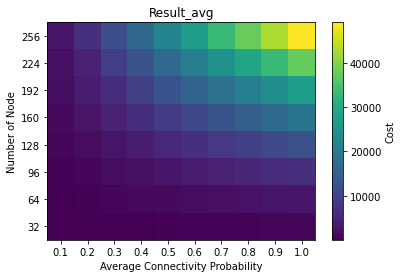

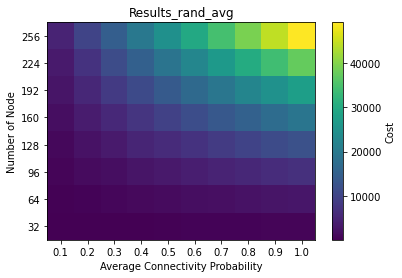

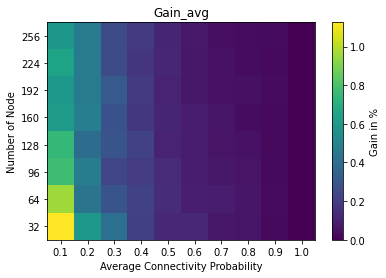

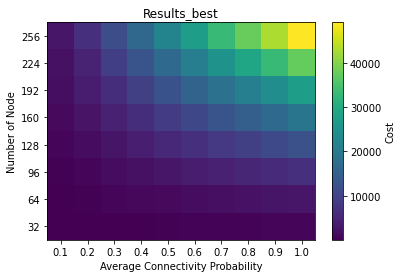

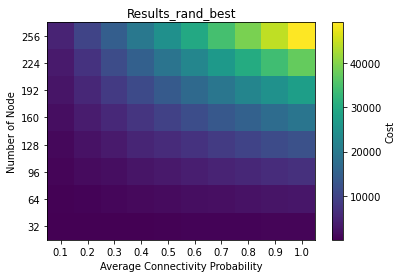

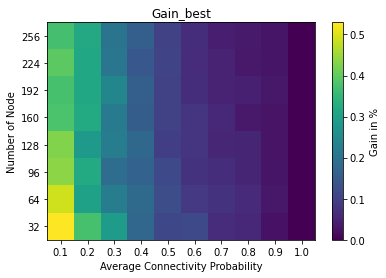

In [58]:
plt.figure()
plot3D([0,1],[0,N], Results_avg, 1/K_density, step, "Cost", "Result_avg")

plt.figure()
plot3D([0,1],[0,N],Results_rand_avg,1/K_density, step, "Cost", "Results_rand_avg")

plt.figure()
plot3D([0,1],[0,N],(Results_rand_avg-Results_avg)/Results_avg,1/K_density, step, "Gain in %", "Gain_avg")

plt.figure()
plot3D([0,1],[0,N],Results_best,1/K_density, step, "Cost", "Results_best")

plt.figure()
plot3D([0,1],[0,N],Results_rand_best,1/K_density, step, "Cost", "Results_rand_best")

plt.figure()
plot3D([0,1],[0,N],(Results_rand_best-Results_best)/Results_rand_best,1/K_density, step, "Gain in %", "Gain_best")

# Specific case study

Let's define an another type of Cost Function suited for a specific type of architecture

##Definig the Cost Function

In [59]:
# M is the number of neurons per core at the highest level
# C is the number of cores per level
# len(A) = M*C
@jit
def cost_HW_reccursive(A, C, M, level):
  if level <= 0 : return 0
  maxFI = M//(2**(level))
  nC = len(A)//C
  tot_error = 0
  for i in range(C):
    for j in range(C):
      to_treat = A[nC*i: nC*(i+1), nC*j: nC*(j+1)]
      if i==j :
        error =  (cost_HW_reccursive(to_treat, C, M, level-1))
      else : # i!=j
        FI = np.sum(to_treat,axis = 0)
        error = np.sum((FI>maxFI)*(FI-maxFI)) 
        #error = np.sum(np.sum(to_treat,axis = 0)>maxFI)

      tot_error += error
      # if error != 0:
      #    print("ERROR, ind:[",i,";",j,"], @level :", level, ", found :", np.sum(to_treat,axis = 0), " instead of : ", maxFI)
        
  return tot_error


class Cost_HW(Cost):
  def __init__(self, C, level, length):
    self.C = C
    self.level = level
    self.swapped_i = np.zeros(length)
    self.swapped_j = np.zeros(length)
    self.X = np.zeros((length, length))

  def cost(self, A):
    return cost_HW_reccursive(A, self.C, len(A)//(self.C**self.level) , self.level)

  def cost_update(self, A, i, j):
    old_cost = cost_HW_reccursive(A, self.C, len(A)//(self.C**self.level) , self.level)
    np.copyto(self.X, A) 
    swap(self.X, self.swapped_j, i, j)
    new_cost = cost_HW_reccursive(self.X, self.C, len(A)//(self.C**self.level) , self.level)

    return new_cost-old_cost

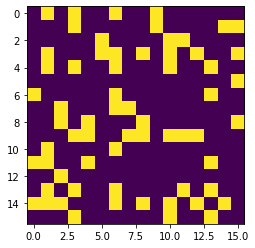

In [71]:
A = create_random(16,4)
plt.imshow(A)

In [72]:
MyCost = Cost_HW(2, 2, len(A))
print("Initial cost",MyCost.cost(A))
print("update : ",MyCost.cost_update(A,0,8))
A = swap(A,np.zeros(len(A)),0,8)
print("Final cost",MyCost.cost(A))


Initial cost 18.0
update :  1.0
Final cost 19.0


## Testing

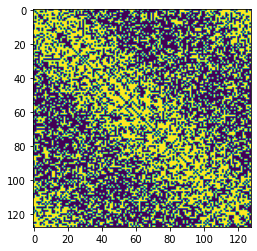

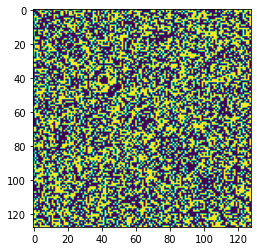

In [62]:
A = create_WS(128,60)
plt.imshow(A)
plt.figure()
A_shuffled = shuffle(A)
plt.imshow(A_shuffled)

INITIAL COST =  4464.0


Iteration number: 5: 100%|██████████| 128/128 [00:01<00:00, 83.02it/s]


FINAL COST =  3704.0
Count swap =  319 , proportion :  0.00389404296875
Count notwap =  81601 , proportion :  0.99610595703125


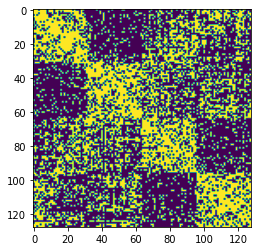

In [73]:
A = create_diago_chenxi(128,54)
A_shuffled = shuffle(A)
MyCost = Cost_HW(4,2,len(A))

Result = mapping(A_shuffled, MyCost, debug=True)

plt.imshow(Result)

## Gain with the algo

In [74]:
Cost_func = lambda x: Cost_HW(4,2,x)
matrix_generator = create_WS
N = 256
step = 64
K_density = 5
test = 1

(Results_best, Results_rand_best, Results_avg, Results_rand_avg) = gain_map(Cost_func, matrix_generator, N, step, K_density, test)

Treating for N = 256: 100%|██████████| 5/5 [04:45<00:00, 57.17s/it]


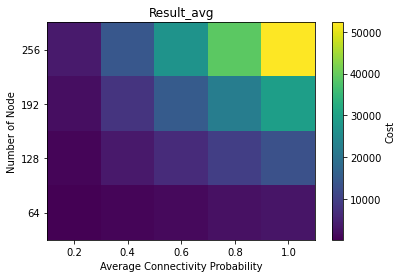

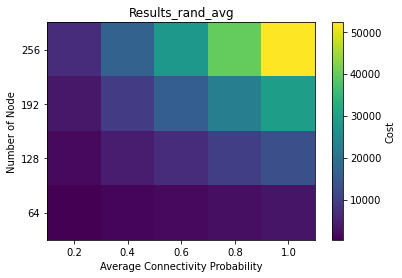

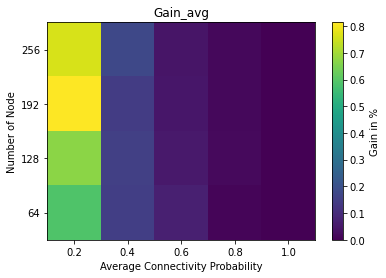

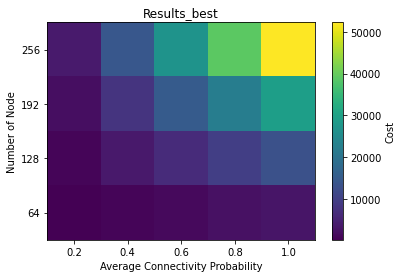

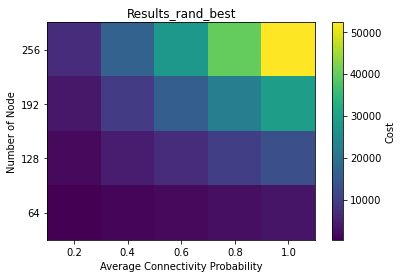

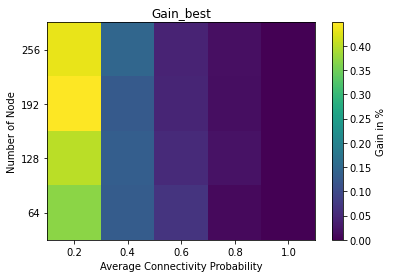

In [75]:
plt.figure()
plot3D([0,1],[0,N], Results_avg, 1/K_density, step, "Cost", "Result_avg")

plt.figure()
plot3D([0,1],[0,N],Results_rand_avg,1/K_density, step, "Cost", "Results_rand_avg")

plt.figure()
plot3D([0,1],[0,N],(Results_rand_avg-Results_avg)/Results_avg,1/K_density, step, "Gain in %", "Gain_avg")

plt.figure()
plot3D([0,1],[0,N],Results_best,1/K_density, step, "Cost", "Results_best")

plt.figure()
plot3D([0,1],[0,N],Results_rand_best,1/K_density, step, "Cost", "Results_rand_best")

plt.figure()
plot3D([0,1],[0,N],(Results_rand_best-Results_best)/Results_rand_best,1/K_density, step, "Gain in %", "Gain_best")